In [1]:
import pickle as pkl
import pandas as pd
from pandas import DataFrame as df
from collections import defaultdict
import scipy.stats as stats
import numpy as np
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

In [2]:
HW_data = pkl.load(open('pkl/HW_df.pkl', 'rb'))

In [3]:
cols = HW_data.columns
HW_data['username'] = HW_data.index

In [4]:
problems = list(set([(c[0],c[1]) for c in cols if len(c)==3]))

In [5]:
def get_hint_count(user_list):
    hint_count = defaultdict(list)
    for ind, row in HW_data.iterrows():
        if not ind in user_list:
            continue
        col_ind = 0
        row_fine = row.fillna(-111)
        single_count = defaultdict(int)
        for ro in row_fine:
            if col_ind >= len(row)-1:
                continue
            title = cols[col_ind]
            pro_id = (title[0],title[1])
            if ro == -111:
                single_count[pro_id] += 0
            else:
                hint_c = [s[3]=='Hint' for s in ro]
                su = sum(hint_c)
                single_count[pro_id] += su
            col_ind += 1
        for p in problems:
            hint_count[p].append(single_count[p])
    return hint_count

def add_to_df(fea_name, fea_df):
    for k in hint_count.keys():
        hints_df[(k[0], k[1], fea_name)] = fea_df[k]

In [6]:
final_df = pd.read_pickle('pkl/final_df.pkl')

In [7]:
final_df.columns

Index([u'Total Score', u'Submission Time', u'1: Combinatorics',
       u'2: Two Pairs', u'3.1: Part 1-3', u'3.2: Part 4-6',
       u'4: Color-blindness', u'5: CDF', u'6.1: Markov', u'6.2: Chebyshev',
       u'7: True/False', u'8.1: Distribution of X', u'8.2: Distribution of Y',
       u'8.3: Relationship between X and Y', u'9.1: alpha = 2',
       u'9.2: alpha = 3', u'9.3: alpha = 4', u'11: Hypothesis Testing',
       u'strong', u'weak', u'mid', u'group', u'username', u'10: Poisson'],
      dtype='object')

In [8]:
weak_final = final_df[final_df['Total Score'] <= final_df['Total Score'].mean()]
hints_df = df(weak_final['username'])

In [9]:
hint_count = get_hint_count(weak_final['username'])
add_to_df('hint_count', hint_count)

In [10]:
def statistics(h_df, noh_df, final_col, print_enabled=True):
    h = len(h_df)
    no_h = len(noh_df)
    if h == 0 or no_h == 0:
        return
    hint_mean = h_df[final_col].mean()
    nh_mean = noh_df[final_col].mean()
    hint_std = h_df[final_col].std()
    nh_std = noh_df[final_col].std()
    
    if(print_enabled):
        print h
        print no_h
        print 'with_hint: ', h/(h+no_h*1.)
        print 'with_no_hint: ', no_h/(h+no_h*1.)

        print '\n mean'
        print hint_mean
        print nh_mean

        print '\n std'
        print hint_std
        print nh_std

        print '\n ttest'
    return stats.ttest_ind_from_stats(hint_mean,hint_std, h, nh_mean, nh_std, no_h), hint_mean, nh_mean

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt
def plot_hints(x, y_hint, y_nohint):
    plt.plot(x, y_hint, label='hint')
    plt.plot(x, y_nohint, label='no hint')
    plt.legend(loc=4)
    plt.xticks(x)

In [12]:
assign = pd.read_pickle('assignment_table.pkl')

In [13]:
assign.columns

Index([u'ID', u'USERNAME', u'NAME', u'EMAIL', u'WEEK4', u'WEEK5', u'WEEK6',
       u'WEEK7', u'WEEK8', u'WEEK9', u'WEEK10'],
      dtype='object')

In [14]:
stu = hints_df.username.tolist()
assign = assign.set_index('USERNAME')
filtered_assign = assign.ix[stu]

In [15]:
hints_df[('4','assign')] = filtered_assign['WEEK4']
hints_df[('5','assign')] = filtered_assign['WEEK5']
hints_df[('6','assign')] = filtered_assign['WEEK6']
hints_df[('7','assign')] = filtered_assign['WEEK7']
hints_df[('8','assign')] = filtered_assign['WEEK8']

In [16]:
features_df = pd.read_pickle('pkl/old_features_df.pkl')

In [17]:
features_df.columns

Index([u'group', u'average_tries', u'ave_time_between_tries', u'att_problems',
       u'att_var', u'time_distri', u'num_correct_pros', u'ave_time_spent',
       u'sum_of_time_each_part', u'ave_exp_count'],
      dtype='object')

In [21]:
def get_time_diff(stu):
    tim_diff = defaultdict(list)
    for ind, row in HW_data.iterrows():
        if not ind in stu:
            continue
        col_ind = 0
        row_fine = row.fillna(-111)
        single_count = defaultdict(int)
        for ro in row_fine:
            if col_ind >= len(row)-1:
                continue
            title = cols[col_ind]
            pro_id = (title[0],title[1])
            if ro == -111:
                single_count[pro_id] += 0
            elif len(ro) > 0:
                t1 = pd.to_datetime(ro[0][0])
                t2 = pd.to_datetime(ro[-1][0])
                tmp = t2-t1
                single_count[pro_id] += tmp.seconds
            col_ind += 1
        for p in problems:
            tim_diff[p].append(single_count[p])
    return tim_diff

def get_tries(stu):
    tries_count = defaultdict(list)
    for ind, row in HW_data.iterrows():
        if not ind in stu:
            continue
        col_ind = 0
        row_fine = row.fillna(-111)
        single_count = defaultdict(int)
        for ro in row_fine:
            if col_ind >= len(row)-1:
                continue
            title = cols[col_ind]
            pro_id = (title[0],title[1])
            if ro == -111:
                single_count[pro_id] += 0
            elif len(ro) >= 0:
                single_count[pro_id] += len(ro)
            col_ind += 1
        for p in problems:
            tries_count[p].append(single_count[p])
    return tries_count

def get_time_spent(stu):
    tim_diff = defaultdict(list)
    for ind, row in HW_data.iterrows():
        if not ind in stu:
            continue
        col_ind = 0
        row_fine = row.fillna(-111)
        single_count = defaultdict(int)
        for ro in row_fine:
            if col_ind >= len(row)-1:
                continue
            title = cols[col_ind]
            pro_id = (title[0],title[1])
            if ro == -111:
                single_count[pro_id] += 0
            elif len(ro) > 0:
                for r in range(len(ro)-1):
                    t1 = pd.to_datetime(ro[r][0])
                    t2 = pd.to_datetime(ro[r+1][0])
                    tmp = t2-t1
                    if tmp.seconds//60 < 10:
                        single_count[pro_id] += tmp.seconds
            col_ind += 1
        for p in problems:
            tim_diff[p].append(single_count[p])
    return tim_diff

In [22]:
#add_to_df('time_diff', get_time_diff(stu))
#add_to_df('tries', get_tries(stu))
#add_to_df('time_spent', get_time_spent(stu))

In [32]:
def fea_p_val(fea_name):
    p_vals = []
    stat = []
    h = []
    nh = []
    pros_stat = []
    for p in sorted(problems):
        if int(p[0]) < 4:
            continue
        pn = (p[0], p[1], 'hint_count')
        h_df = hints_df[(hints_df[pn] > 0)]
        nh_df = hints_df[(hints_df[pn] == 0) & (hints_df[(p[0],'assign')] == '0')]
        if len(h_df) == 0 or len(nh_df) == 0:
            continue
        pros_stat.append(p)
        st = statistics(h_df, nh_df, (p[0],p[1],fea_name), False)
        if st and st[1] == st[1]:
            p_vals.append(st[0][1])
            stat.append(p)
            h.append(h_df[p[0],p[1],fea_name].mean())
            nh.append(nh_df[p[0],p[1],fea_name].mean())
    return p_vals, stat, h, nh

def fig_setting():
    plt.figure(figsize=(10,5))
    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    return plt

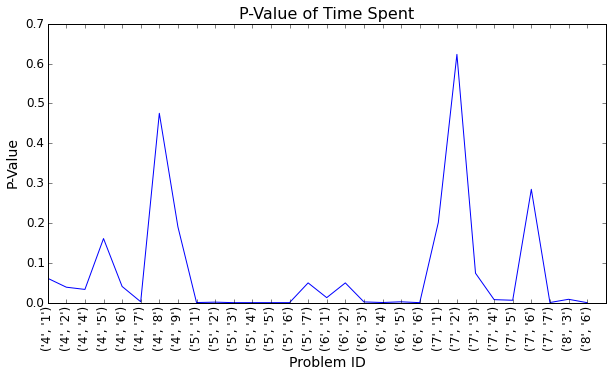

In [33]:
p_vals, pros_time, h_time, nh_time = fea_p_val('time_spent')
plt = fig_setting()
plt.plot(p_vals)
plt.xticks(range(0,len(pros_time)), pros_time, rotation='vertical')
plt.title('P-Value of Time Spent')
plt.xlabel('Problem ID')
plt.ylabel('P-Value')
#plt.savefig('times_p.png', bbox_inches='tight', pad_inches=0.2)

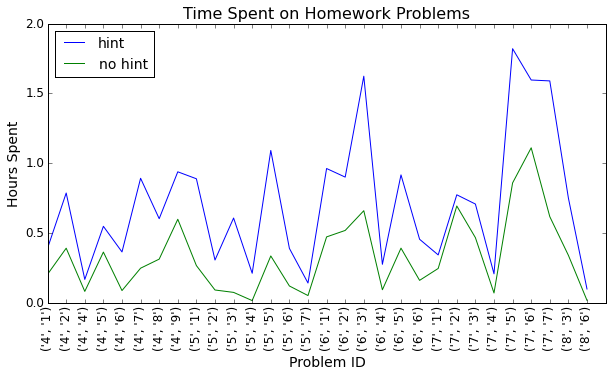

In [45]:
plt = fig_setting()
plot_hints(range(0,len(pros_time)), np.array(h_time)/3600., np.array(nh_time)/3600.)
plt.xticks(range(0,len(pros_time)), pros_time, rotation='vertical')
plt.title('Time Spent on Homework Problems')
plt.xlabel('Problem ID')
plt.ylabel('Hours Spent')
plt.legend(loc=2)
plt.savefig('times_analysis_weak.png', bbox_inches='tight', pad_inches=0.2)

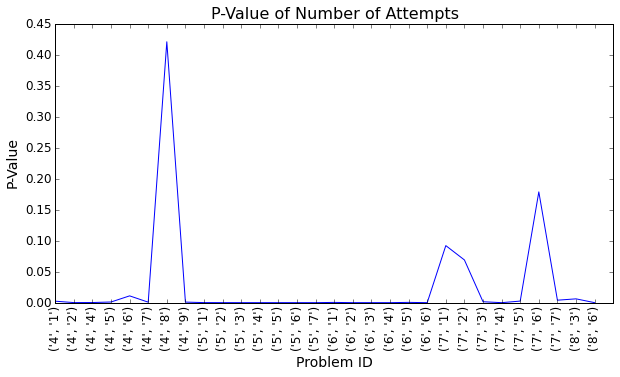

In [34]:
p_vals, pros_tries, h_tries, nh_tries = fea_p_val('tries')
plt = fig_setting()
plt.plot(p_vals)
plt.xticks(range(0,len(pros_tries)), pros_tries, rotation='vertical')
plt.title('P-Value of Number of Attempts')
plt.xlabel('Problem ID')
plt.ylabel('P-Value')
#plt.savefig('tries_p.png', bbox_inches='tight', pad_inches=0.2)

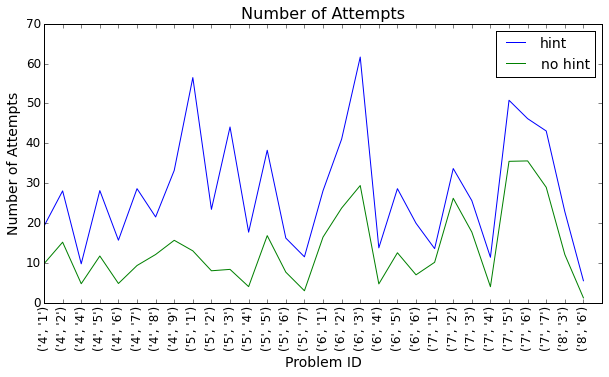

In [46]:
plt = fig_setting()
plot_hints(range(0,len(pros_tries)), h_tries, nh_tries)
plt.xticks(range(0,len(pros_tries)), pros_tries, rotation='vertical')
plt.title('Number of Attempts', fontsize=BIGGER_SIZE)
plt.xlabel('Problem ID')
plt.ylabel('Number of Attempts')
plt.legend(loc=1)
plt.savefig('tries_analysis_weak.png', bbox_inches='tight', pad_inches=0.2)

In [37]:
### Average tries for students with no hint
nh_ave = {}
for p in sorted(problems):
    if int(p[0]) < 4:
        continue
    pn = (p[0], p[1], 'hint_count')
    nh_df = hints_df[(hints_df[pn] == 0) & (hints_df[(p[0],'assign')] == '0')]
    if len(nh_df) == 0:
        continue
    nh_ave[(p[0],p[1],'nh_ave_tries')] = nh_df[(p[0],p[1],'tries')].mean()

In [38]:
### Average tries for students with hints
h_ave = {}
for p in sorted(problems):
    if int(p[0]) < 4:
        continue
    pn = (p[0], p[1], 'hint_count')
    h_df = hints_df[hints_df[pn] > 0]
    if len(h_df) == 0:
        continue
    h_ave[(p[0],p[1],'h_ave_tries')] = h_df[(p[0],p[1],'tries')].mean()

In [39]:
### Find the first part with hints for each student
first_hint_pro = {}
for ind, row in hints_df.iterrows():
    weekly_first = defaultdict(str)
    for p in sorted(problems):
        if int(p[0]) < 4:
            continue
        h_count = (p[0], p[1], 'hint_count')
        assign = (p[0], 'assign')
        if not weekly_first[p[0]] and row[assign] == '1' and row[h_count] > 0:
            weekly_first[p[0]] = p[1]
    first_hint_pro[ind] = weekly_first

In [40]:
### Find sum of attempts for problems with hints.
h_tries_sum = defaultdict(int)
h_pros = defaultdict(list)
### Find sum of attempts for problems without hint.
h_na_tries_sum = defaultdict(int)
h_na_pros = defaultdict(list)
h_na_tries_sum_weekly = {}

### Find sum of attempts for problems without hint because students didn't click show hint button.
h_nc_tries_sum = defaultdict(int)
h_nc_pros = defaultdict(list)

not_click_stu = defaultdict(list)

for ind, row in hints_df.iterrows():
    h_na_weekly_sum = defaultdict(int)
    for p in sorted(pros_tries):
        if int(p[0]) < 4:
            continue
        h_count = (p[0], p[1], 'hint_count')
        assign = (p[0],'assign')
        if row[assign] == '0':
            continue
        if first_hint_pro[ind][p[0]]:
            first_pro = int(first_hint_pro[ind][p[0]])
            if int(p[1]) > first_pro and row[h_count] == 0:
                h_na_tries_sum[ind] += row[(p[0],p[1],'tries')]
                h_na_weekly_sum[p[0]] += row[(p[0],p[1],'tries')]
                h_na_pros[ind].append((p[0],p[1]))
            elif row[h_count] != 0:
                h_tries_sum[ind] += row[(p[0],p[1],'tries')]
                h_pros[ind].append((p[0],p[1]))
        else:
            if p[0] not in not_click_stu[ind]:
                not_click_stu[ind].append(p[0])
            h_nc_tries_sum[ind] += row[(p[0],p[1],'tries')]
            h_nc_pros[ind].append((p[0],p[1]))
    h_na_tries_sum_weekly[ind] = h_na_weekly_sum

In [41]:
len(not_click_stu)

60

In [42]:
### Number of attempts on problems with hints but no click.
### Look at students who got hint but did not clicked "show hint" to see whether they perform better
h_nc_diff_count = 0
h_nc_diff = []
h_nc_control_sum_tries = []
h_nc_treatment_sum_tries = []
for name in h_nc_pros:
    nh_sum = 0
    for p in h_nc_pros[name]:
        nh_sum += nh_ave[p[0], p[1], 'nh_ave_tries']
    if nh_sum and h_nc_tries_sum[name]:
        h_nc_control_sum_tries.append(nh_sum)
        h_nc_treatment_sum_tries.append(h_tries_sum[name])
        h_nc_diff.append(nh_sum - h_tries_sum[name])
        h_nc_diff_count += 1
print sum(h_nc_diff)/float(h_nc_diff_count)
stats.ttest_rel(h_nc_control_sum_tries, h_nc_treatment_sum_tries)

-6.89607524647


Ttest_relResult(statistic=-0.38179660484874284, pvalue=0.704230087000697)

In [43]:
### Number of attempts on problems without hint.
h_na_diff_count = 0
h_na_diff = []
h_na_control_sum_tries = []
h_na_treatment_sum_tries = []
for nam in h_na_pros:
    nh_sum = 0
    for p in h_na_pros[nam]:
        nh_sum += nh_ave[p[0], p[1], 'nh_ave_tries']
    h_na_control_sum_tries.append(nh_sum)
    h_na_treatment_sum_tries.append(h_na_tries_sum[nam])
    h_na_diff.append(nh_sum - h_na_tries_sum[nam])
    h_na_diff_count += 1
print sum(h_na_diff)/float(h_na_diff_count)

stats.ttest_rel(h_na_control_sum_tries, h_na_treatment_sum_tries)

13.81443967


Ttest_relResult(statistic=3.3483227357577396, pvalue=0.0011932486667103534)

In [44]:
### Number of attempts on problems with hints.
h_diff_count = 0
h_diff = []
h_control_sum_tries = []
h_treatment_sum_tries = []
for nam in h_pros:
    nh_sum = 0
    for p in h_pros[nam]:
        nh_sum += nh_ave[p[0], p[1], 'nh_ave_tries']
    if nh_sum and h_tries_sum[nam]:
        h_control_sum_tries.append(nh_sum)
        h_treatment_sum_tries.append(h_tries_sum[nam])
        h_diff.append(nh_sum - h_tries_sum[nam])
        h_diff_count += 1
print sum(h_diff)/float(h_diff_count)
stats.ttest_rel(h_control_sum_tries, h_treatment_sum_tries)

-84.4926219732


Ttest_relResult(statistic=-7.1571741243244995, pvalue=1.8724833653827416e-10)

In [ ]:
### Just look at the students in weak group
### Only take the weaker students(from final) do the same experiment all over!

In [ ]:
### Predicting final score